<a href="https://colab.research.google.com/github/pachterlab/CGP_2024_2/blob/main/perturbation_populations_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this notebook we will cluster the nascent and mature mRNA counts from drug-tolerant (DT) PC9 cells, to identify resistant populations of cells. This demonstrates how to cluster perturbation data, and identify multiple perturbed populations even within the same condition.**

## **Read in data and metadata**

In [1]:
#Install
!pip install --quiet monod
!pip install -U --quiet loompy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 546.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.9 MB/s eta 0:00:00


In [2]:
!pip install --quiet anndata

In [3]:
!pip install --quiet scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.6 MB/s eta 0:00:00


In [4]:
#gene length annotation
!wget --content-disposition https://github.com/pachterlab/CGP_2024_2/raw/main/reference/gg_200525_genome_polyA_cum_3

#loom files
!wget --content-disposition https://data.caltech.edu/records/z3qv2-15815/files/example_looms.tar.gz?download=1
!tar -xvf example_looms.tar.gz

--2024-07-06 16:14:41--  https://github.com/pachterlab/CGP_2024_2/raw/main/reference/gg_200525_genome_polyA_cum_3
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pachterlab/CGP_2024_2/main/reference/gg_200525_genome_polyA_cum_3 [following]
--2024-07-06 16:14:42--  https://raw.githubusercontent.com/pachterlab/CGP_2024_2/main/reference/gg_200525_genome_polyA_cum_3
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9325163 (8.9M) [text/plain]
Saving to: ‘gg_200525_genome_polyA_cum_3’

gg_200525_genome_po 100%[===================>]   8.89M  --.-KB/s    in 0.1s    

2024-07-06 16:14:42 (85.5 MB/s) - ‘gg

In [5]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

/usr/local/lib/python3.10/dist-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/usr/local/lib/python3.10/dist-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/usr/local/lib/python3.10/dist-packages/loompy/bus_file.py:1

In [6]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import scipy.stats

import random
import glob
import os

In [7]:
import anndata
import scanpy as sc

## **Clustering of drug-tolerant cells into populations**

Select gene for inference

In [8]:
#Threshold for filtering genes based on expression patterns
def nb_thresh(U,S,var_t = 1.5,u_min =0.02,s_min =0.02):
    '''
    Take in U,S matrices, and find genes that meet var/mean thresh
    U,S are cellxgene
    '''
    var_threshold = var_t
    U_mean = U.mean(0)
    S_mean = S.mean(0)
    U_var = U.var(0)
    S_var = S.var(0)

    #if l == '/home/tchari/counts/allen_bivi/loom/processed_allen_B02H01A02_raw.loom':
    u_min = u_min
    s_min =  s_min


    fitted_idx = (U_mean > u_min) & (S_mean > s_min) \
    & (((U_var-U_mean)/(U_mean**2)) > var_threshold)\
    & (((S_var-S_mean)/(S_mean**2)) > var_threshold)\
    & (np.abs(np.log(S_mean/U_mean)) < 4)
    #((U_mean/S_mean) > 1.0) #labeled mRNA (new synth) is mainly intronic counts

    #(np.abs(np.log(S_mean/U_mean)) < 4)


    return fitted_idx

In [9]:
#Get full count matrices and barcodes
ds = lp.connect('./all_cancer_dt_sub2.loom')
U = ds.layers['unspliced'][:].T
S = ds.layers['spliced'][:].T
bars = ds.ca['barcode']
g_names = ds.ra['gene_name']
ds.close()

In [10]:
#Get Highly Variable Genes (HVGs) using 'standard' procedure for scRNAseq data

adata = anndata.AnnData(X=S)
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
g_filt_hvg = adata.var.highly_variable

In [11]:
#Filter for overdispersed *and* enough U/S counts for clustering
g_filt = nb_thresh(U,S)


final_filt =  g_filt_hvg & g_filt #Filter for hvgs that meet expression thresholds
final_names = g_names[final_filt]


<ipython-input-8-4fceaa47b944>:19: RuntimeWarning: invalid value encountered in divide
  & (((U_var-U_mean)/(U_mean**2)) > var_threshold)\
<ipython-input-8-4fceaa47b944>:21: RuntimeWarning: divide by zero encountered in divide
  & (np.abs(np.log(S_mean/U_mean)) < 4)


In [12]:
print('No. genes selected: ',np.sum(final_filt))

No. genes selected:  53


**Run meK-Means clustering on unspliced and spliced counts**

In [13]:
l = './all_cancer_dt_sub2.loom'

transcriptome_filepath = './gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

In [14]:
#Set up files for meK-Means with different possible K values
Ks= [2,5,10]
all_looms = [l]*len(Ks)

data_names = ['Day3_k_'+str(i) for i in Ks]
print(data_names)

['Day3_k_2', 'Day3_k_5', 'Day3_k_10']


In [15]:
result_strings = []

#Use Filtered genes that meet thresholds and are in literature


#Define bounds for params
phys_lb = [-2.0, -1.8, -1.8]
phys_ub = [4.2, 2.5, 2.5]
samp_lb = [-7.333333333333333, -1.25]
samp_ub = [-7.333333333333333, -1.25]
gridsize = [1,1] #Already have tech params

epochs = 10

#Set up files for Monod, fit for previously selected genes
dir_string,dataset_string = monod.preprocess.construct_batch(all_looms, \
                                         transcriptome_filepath, \
                                         data_names, \
                                         attribute_names=attribute_names,\
                                         batch_location='./',\
                                         meta='Day3_DT',batch_id=1,\
                                         n_genes=len(final_names),exp_filter_threshold=None,
                                         viz=False,genes_to_fit=final_names,cf=None)



In [16]:
# ---------------- meK-Means Inference ----------------
for x in range(len(dataset_string)):
    #Define model with bursty transcription and Poisson molecule capture/sampling
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    #Set up mminference parameters
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_string[x],fitmodel,k=Ks[x], epochs=epochs ,use_lengths = True,
                gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})

    #Read in loom file with filtered barcodes
    search_data = monod.extract_data.extract_data(all_looms[x], transcriptome_filepath, data_names[x],
                dataset_string[x], dir_string, viz=False, dataset_attr_names=attribute_names,cf=None)

    #Run inference(fit_all_grid_points()) and Save result file strings
    full_result_string = inference_parameters.fit_all_grid_points(1,search_data)

    result_strings.append(full_result_string)
    print('Result: ',full_result_string)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in divide
  divids = (1e4/tots)[:,None]
/usr/local/lib/python3.10/dist-packages/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


mstep self.weights:  [0.5819275 0.4180725]
Q Function:  -318072.8163304506

mstep self.weights:  [0.58504681 0.41495319]
Q Function:  -316416.6687884694

mstep self.weights:  [0.57723189 0.42276811]
Q Function:  -316274.9953797683

mstep self.weights:  [0.56037143 0.43962857]
Q Function:  -316186.5214650027

mstep self.weights:  [0.53817778 0.46182222]
Q Function:  -316187.5533271545

mstep self.weights:  [0.51618509 0.48381491]
Q Function:  -315960.06979053316

mstep self.weights:  [0.50032573 0.49967427]
Q Function:  -316034.5245149763

mstep self.weights:  [0.27439286 0.72560714]
Q Function:  -326881.7674832317

mstep self.weights:  [0.27128748 0.72871252]
Q Function:  -315252.9124269108

mstep self.weights:  [0.27357741 0.72642259]
Q Function:  -315141.5578814005

Result:  ['./gg_240706_029_Day3_DT_1/Day3_k_2/Bursty_Poisson_1x1/grid_scan_results_0.res', './gg_240706_029_Day3_DT_1/Day3_k_2/Bursty_Poisson_1x1/grid_scan_results_1.res']


/usr/local/lib/python3.10/dist-packages/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in divide
  divids = (1e4/tots)[:,None]
/usr/local/lib/python3.10/dist-packages/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


mstep self.weights:  [0.22403688 0.17802983 0.17469552 0.21575402 0.20748375]
Q Function:  -324290.1723130267

mstep self.weights:  [0.23295361 0.21636883 0.06262635 0.2485405  0.23951071]
Q Function:  -323302.8664421741

mstep self.weights:  [0.23626256 0.18523338 0.06255502 0.25433659 0.26161245]
Q Function:  -320955.7734101941

mstep self.weights:  [0.25230203 0.17344252 0.05603615 0.26310513 0.25511416]
Q Function:  -316121.05218461744

mstep self.weights:  [0.26340619 0.16557503 0.04838607 0.27225073 0.25038197]
Q Function:  -315514.53287262254

mstep self.weights:  [0.36396961 0.00695521 0.01899153 0.31719055 0.2928931 ]
Q Function:  -318675.7484246163

mstep self.weights:  [3.94600835e-01 8.11091285e-10 3.57517672e-03 3.04927002e-01
 2.96896985e-01]
Q Function:  -314872.25679515407

mstep self.weights:  [4.05557696e-01 8.63856964e-11 1.29607050e-03 2.99749130e-01
 2.93397103e-01]
Q Function:  -314476.9505015599

mstep self.weights:  [4.16184283e-01 8.63856329e-11 1.32759056e-05 

/usr/local/lib/python3.10/dist-packages/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in divide
  divids = (1e4/tots)[:,None]
/usr/local/lib/python3.10/dist-packages/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


mstep self.weights:  [0.10146684 0.09799422 0.09642963 0.09933409 0.10044269 0.0937928
 0.10443568 0.09243099 0.12007635 0.0935967 ]
Q Function:  -335931.8137551122

mstep self.weights:  [0.07891653 0.18561932 0.00383512 0.01436321 0.19470616 0.05134197
 0.07119187 0.17877758 0.18354406 0.03770418]
Q Function:  -337496.9828456904

mstep self.weights:  [9.58523773e-02 1.57300606e-01 8.02991126e-08 9.13603035e-04
 2.09956685e-01 8.11863991e-02 2.35574675e-02 1.91406135e-01
 1.95678587e-01 4.41480599e-02]
Q Function:  -322390.1097329029

mstep self.weights:  [1.02539440e-01 1.44173501e-01 8.72740445e-11 1.12305207e-06
 2.11807289e-01 1.01782679e-01 7.46064054e-03 1.91351269e-01
 1.94438975e-01 4.64450835e-02]
Q Function:  -319424.89968954615

mstep self.weights:  [1.37349946e-01 2.03719682e-02 8.63860935e-11 3.87511878e-10
 2.45970784e-01 1.16352246e-01 3.11997580e-03 2.21371570e-01
 2.04494331e-01 5.09691793e-02]
Q Function:  -319801.9335172468

mstep self.weights:  [1.59693549e-01 2.860

In [17]:
sr = []
for strings in result_strings:
    sr += [[monod.analysis.load_search_results(i) for i in strings]]

#SearchData objects, with U/S
sd = []
for strings in result_strings:

    sd += [[monod.analysis.load_search_data(i[:i.find('Bursty')]+'raw.sd') for i in strings]]

len(sd)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3

View results and fits for different K values

In [18]:
def check_at_bounds(phys_params,thr=0.01,phys_lb=[-2.0, -1.8, -1.8 ],phys_ub=[4.2, 2.5, 2.5]):
    #Check for genes where parameter fits are close to boundary of grid
    x = np.any(np.logical_or(
        np.array(phys_lb)+thr > phys_params,
        np.array(phys_ub)-thr < phys_params) ,1)
    return x

In [19]:
def get_assigns(sr):
    '''
    Get cell cluster assignments
    '''
    cats = np.array([None]*len(sr[0].filt))
    for r in sr:
        cats[r.filt] = r.assigns
    return cats

In [20]:
def vis_metrics(results,title,ks,figsize=(18, 5),s=50,fname=None):
    '''
    Visualize -Q function and KLD over epochs, and -AIC for final model inference

    results: list of len num_ks, of lists of SearchResults objs per K tested (e.g. [[SearchResults],[SearchResults,SearchResults]] for K=1&2)
    title: title string for leftmost, plot
    ks: list of ks tested (e.g. [1,2])
    figsize: tuple for size of figure
    s: size of dots in scatterplot
    save_file: string, output file to save image

  '''

    num_ks = len(results)
    sets = []
    qs = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()

    aic = []
    fin_k = []
    kls = []

    epoch = len(results[0][0].all_qs.flatten())
    epos = list(range(1,epoch+1))*num_ks

    for i in range(num_ks):

        qs += list(-1*results[i][0].all_qs.flatten())
        sets += [ks[i]]*epoch
        aic += [results[i][0].aic[0]]
        fin_k += [len(results[i])]


        concat_klds = []
        ks_used = []
        for r in results[i]:
            concat_klds += [r.all_klds[0,:,:]]
            ks_used += [r.assigns]

        concat_klds = np.array(concat_klds)
        concat_klds = concat_klds.reshape((concat_klds.shape[1], concat_klds.shape[2],concat_klds.shape[0]))

        kls += list(np.mean(np.sum(concat_klds[:,:,:],axis=1),axis=1)) #Sum of klds across k clusters


    res['Q'] = qs
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]

    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k

    #Plot Q function over epochs
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)

    sns.lineplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    g1=sns.scatterplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('-Q')
    ax[0].legend(
          title='Set K')
    ax[0].set_title(title)
    sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))


    #Plot klds over epochs
    g2=sns.lineplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')
    ax[1].legend(
          title='Set K')
    sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))



    #Plot aics
    g3=sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final Assigned k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='Set K')
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))


    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

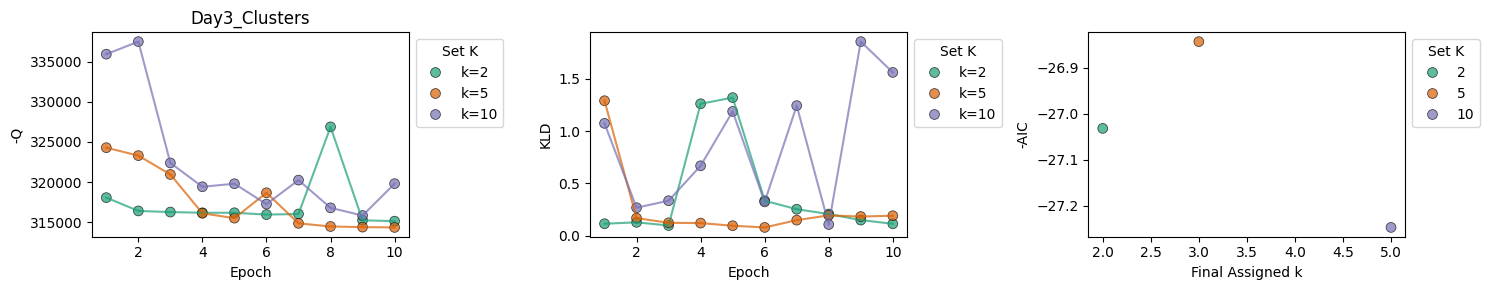

In [21]:
vis_metrics(sr,'Day3_Clusters',Ks,figsize=(15,3),fname='DT_k_metrics.pdf')

## **DE-$\theta$ analysis between learned clusters**

In [22]:
def make_fcs(sr,sd,clus1=0,clus2=1,gf_rej=False,thrpars=2,thrmean=1,outlier_de=True,nuc=False,correct_off=False):
    '''
    Utilize different metrics to find fold-changes (FCs) between cluster parameters

    sr: list of SearchResults objects from meK-Means runs
    sd: SearchData object that corresponds to full, input data
    clus1: cluster 1 (to compare FCS of cluster 1/cluster 2 )
    clus2: cluster 2 (to compare FCS of cluster 1/cluster 2 )
    gf_rej: whether to use boolean list of rejected genes from both clusters
    thrpars: FC threshold value (to call DE-theta genes)
    thrmean: Mean S expression threshold value, for genes to consider
    outlier_de: Use iterative outlier calling procedure to assign DE-theta genes (see Monod https://github.com/pachterlab/monod_examples/blob/main/Monod_demo.ipynb)
    nuc: is this nuclear RNA data
    correct_off: boolean to correct parameter offset with ODR
    '''

    all_filt_fcs = pd.DataFrame()
    fcs,types,which_pair,highFC,spliceFC,g_names,out_de = ([] for i in range(7))

    ind1 = [i for i in range(len(sr)) if clus1 == sr[i].assigns][0]
    ind2 = [i for i in range(len(sr)) if clus2 == sr[i].assigns][0]

    sr1 = sr[ind1]
    sr2 = sr[ind2]
    if correct_off:
        param_names = sr1.model.get_log_name_str()
        offsets = []
        par_vals = np.copy(sr2.param_estimates)
        for k in range(3):
            m1 = sr1.param_estimates[0,:,k]
            m2 = sr2.param_estimates[0,:,k]
            offset = analysis.diffexp_fpi(m1,m2,param_names[k],viz=False)[1]
            par_vals[0,:,k] -= offset

        fc_par = (sr1.param_estimates-par_vals)/np.log10(2)
    else:
        fc_par = (sr1.param_estimates-sr2.param_estimates)/np.log10(2)  #Get FCs between cluster params

    print('fc_par.shape: ',fc_par.shape)
    if nuc:
        fc_s_par = np.log2(sd.layers[0][:,sr1.filt].mean(1)/sd.layers[0][:,sr2.filt].mean(1))
    else:
        fc_s_par = np.log2(sd.layers[1][:,sr1.filt].mean(1)/sd.layers[1][:,sr2.filt].mean(1)) #Get spliced FCs

    print('fc_s_par.shape: ',fc_s_par.shape)

    if outlier_de:
        dr_analysis = monod.analysis.diffexp_pars(sr1,sr2,viz=True,modeltype='id',use_sigma=True)
        par_bool_de = dr_analysis[1].T

    parnames = ('b','beta','gamma')


  #-----is parameter FC significant -----
    if gf_rej is False:
        gf_rej = [True]*sd.n_genes
    else:
        gf_rej = (~sr1.rejected_genes) & (~sr2.rejected_genes)

    for n in range(len(parnames)):
        #Boolean for if large param FC and not rejected gene (with minimum expression)
        if nuc:
            gf_highnoise = (np.abs(fc_par[0,:,n])>thrpars)  \
                & ((sd.layers[0][:,sr1.filt].mean(1)>thrmean) | (sd.layers[0][:,sr2.filt].mean(1)>thrmean)) \
                & gf_rej
        else:
            gf_highnoise = (np.abs(fc_par[0,:,n])>thrpars)  \
                & ((sd.layers[1][:,sr1.filt].mean(1)>thrmean) | (sd.layers[1][:,sr2.filt].mean(1)>thrmean)) \
                & gf_rej

        #Boolean for FC (above) but no FC detected at S-level
        gf_highnoise_meanS = gf_highnoise & (np.abs(fc_s_par)<1) & gf_rej

        #Boolean for FC (above)
        gf_onlyhigh = gf_highnoise & gf_rej

        #For dataframe
        fcs += list(fc_par[0,gf_rej,n])
        g_names += list(sr1.gene_names[gf_rej])
        which_pair += [[sr1.assigns,sr2.assigns]]*np.sum(gf_rej)
        highFC += list(gf_onlyhigh[gf_rej])
        spliceFC += list(gf_highnoise_meanS[gf_rej])
        types += [parnames[n]]*np.sum(gf_rej)
        if outlier_de:
            out_de += list(par_bool_de[gf_rej,n])

    if outlier_de:
        all_filt_fcs['deTheta_outlier'] = out_de

    all_filt_fcs['log2FC'] = fcs
    all_filt_fcs['gene'] = g_names
    all_filt_fcs['cluster_pair'] = which_pair
    all_filt_fcs['deTheta_FC'] = highFC
    all_filt_fcs['deTheta_noDeMuS'] = spliceFC
    all_filt_fcs['param'] = types

    return all_filt_fcs


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
#Get params for each gene, which cluster it marks, and whether it's DE in any param
def get_gene_DE(all_filt_fcs):
    bs = all_filt_fcs[all_filt_fcs.param.isin(['b'])].log2FC
    betas = all_filt_fcs[all_filt_fcs.param.isin(['beta'])].log2FC
    gammas = all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].log2FC
    highFCs = np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].deTheta_FC)
    noSpliceFCs = np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].deTheta_noDeMuS) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].deTheta_noDeMuS) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].deTheta_noDeMuS)

    names = all_filt_fcs[all_filt_fcs.param.isin(['b'])].gene

    dom = []
    for i in range(len(noSpliceFCs)):
        fc_b = list(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].log2FC)[0]
        fc_beta = list(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].log2FC)[0]
        fc_gamma = list(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].log2FC)[0]

        sig_b = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].deTheta_noDeMuS))[0]
        sig_beta = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].deTheta_noDeMuS))[0]

        sig_gamma = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].deTheta_noDeMuS))[0]


        pairs = list(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].cluster_pair)[0]

# ----- Cell type 'marker' means increase in burst freq,burst,or splicing, or decrease in deg (increased 'stability') ----

        #Increase in burst freq (not outweighted by burst size)
        if (-1*fc_beta > 0 and sig_beta and -1*fc_gamma > 0 and sig_gamma) :
            if (np.abs(fc_b) < np.abs(fc_beta)):
                dom += [pairs[0]]
            elif (fc_b > 0 and sig_b):
                dom += [pairs[0]]
            elif (fc_b < 0 and sig_b):
                dom += [pairs[1]]
            else:
                dom += ['None']
        elif (fc_beta > 0 and sig_beta and fc_gamma > 0 and sig_gamma) :
            if (np.abs(fc_b) < np.abs(fc_beta)):
                dom += [pairs[1]]
            elif (fc_b > 0 and sig_b):
                dom += ['None'] #don't know
            elif (fc_b < 0 and sig_b):
                dom += [pairs[1]]
            else:
                dom += ['None']
        elif sig_b:
            if np.abs(fc_b) > np.abs(fc_beta) and np.abs(fc_b) > np.abs(fc_gamma):
                if fc_b > 0:
                    dom += [pairs[0]]
                else:
                    dom += [pairs[1]]
            elif np.abs(fc_b) < np.abs(fc_beta):
                if fc_beta > 0:
                    dom += [pairs[0]]
                elif fc_beta < 0:
                    dom += [pairs[1]]
            elif np.abs(fc_b) < np.abs(fc_gamma):
                if fc_gamma < 0:
                    dom += [pairs[0]]
                elif fc_gamma > 0:
                    dom += [pairs[1]]
            else:
                dom += ['None']
        elif (fc_beta > 0 and sig_beta):
            dom += [pairs[0]]
        elif (fc_gamma > 0 and sig_gamma): #individual FCs
            dom += [pairs[1]]
        elif  (fc_beta < 0 and sig_beta):
            dom += [pairs[1]]
        elif (fc_gamma < 0 and sig_gamma):
            dom += [pairs[0]]
        else:
            dom += ['None']


    return bs,-1*betas,-1*gammas,dom,highFCs,noSpliceFCs,names #-1 for plotting purposes

In [24]:
#Plot FCs of parameters between two clusters

def plot_de(outs,names_plot,mark_plot,xpos,ypos,arrow,assign_colors,figsize=(10,4),betag=False,xlims=[-10,10],fname=None):
    fig,ax = plt.subplots(1,2,figsize=figsize)

    name_inds = [list(outs[6]).index(i) for i in names_plot]

    labs = np.array(outs[3])
    g=sns.scatterplot(x=list(outs[0][labs =='None']),y=list(outs[1][labs=='None']),
                      hue=list(pd.Categorical(outs[3])[labs=='None']),
                      palette=assign_colors,ax=ax[0],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

    sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==False)]),
                    y=list(outs[1][(labs!='None') &  (outs[5]==False)]),
                    hue=list(pd.Categorical(outs[3])[(labs!='None') &  (outs[5]==False)]),
                      palette=assign_colors,ax=ax[0],marker='o',alpha=0.6,s=100,edgecolor='black')

    sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==True)]),
                    y=list(outs[1][(labs!='None')  &  (outs[5]==True)]),
                    hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                      palette=assign_colors,ax=ax[0],marker='X',alpha=0.8,s=120,edgecolor='black')

    #Annotate genes
    for n in range(len(names_plot)):
        x=list(outs[0])[name_inds[n]]
        y=list(outs[1])[name_inds[n]]
        h=[pd.Categorical(outs[3])[name_inds[n]]]
        if_x=list(outs[5])[name_inds[n]]

        if if_x:
            shape = 'X'
        else:
            shape = 'o'

        if arrow[n]:
            #Replot, so annotated points show up on top
            sns.scatterplot(x=x,
                    y=y,
                    hue=h,
                      palette=assign_colors,ax=ax[0],marker=shape,alpha=0.8,s=120,edgecolor='black',
                           legend=False)

            ax[0].annotate(names_plot[n], (x, y), fontsize=14,
                           xytext=(x+xpos[n],y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                       arrowprops = dict(facecolor=assign_colors[mark_plot[n]],
                                         arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",lw=0.4))
        else:
            #Replot, so annotated points show up on top
            sns.scatterplot(x=x,
                    y=y,
                    hue=h,
                      palette=assign_colors,ax=ax[0],marker=shape,alpha=0.8,s=120,edgecolor='black',
                           legend=False)

            ax[0].annotate(names_plot[n], (x, y),fontsize=14,
                           xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")

    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

    xl =np.asarray([xlims[0],xlims[1]])
    xlx = [xl[0],xl[1]]
    xly = [xl[0],xl[1]]
    ax[0].set_xlim(xlx)
    ax[0].set_ylim(xly)

    ax[0].plot(xl,-xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

    ax[0].set_xlabel(r'$\log_{2}$FC $b$ ',fontsize=14)
    ax[0].set_ylabel(r'$-\log_{2}$FC $\beta$ ',fontsize=14)

    ax[0].tick_params(axis='both', which='major', labelsize=14,)




    if betag == False:
        labs = np.array(outs[3])
        g=sns.scatterplot(x=list(outs[0][labs =='None']),y=list(outs[2][labs=='None']),
                          hue=list(pd.Categorical(outs[3])[labs=='None']),
                          palette=assign_colors,ax=ax[1],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

        sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==False)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==False)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==False)]),
                          palette=assign_colors,ax=ax[1],marker='o',alpha=0.6
                        ,s=100,edgecolor='black')


        sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==True)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==True)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                          palette=assign_colors,ax=ax[1],marker='X',
                        alpha=0.8,s=120,edgecolor='black')
        #Annotate genes
        for n in range(len(names_plot)):
            x=list(outs[0])[name_inds[n]]
            y=list(outs[2])[name_inds[n]]
            h=[pd.Categorical(outs[3])[name_inds[n]]]
            if_x=list(outs[5])[name_inds[n]]

            if if_x:
                shape = 'X'
            else:
                shape = 'o'

            if arrow[n]:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=100,edgecolor='black',
                               legend=False)

                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                           arrowprops = dict(facecolor=assign_colors[mark_plot[n]],
                                             arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",
                                             lw=0.4,))
            else:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)

                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")


        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

        xl =np.asarray([xlims[0],xlims[1]])
        xlx = [xl[0],xl[1]]
        xly = [xl[0],xl[1]]
        ax[1].set_xlim(xlx)
        ax[1].set_ylim(xly)

        ax[1].plot(xl,-xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

        ax[1].set_xlabel(r'$\log_{2}$FC $b$ ',fontsize=14)
        ax[1].set_ylabel(r'$-\log_{2}$FC $\gamma$ ',fontsize=14)

        ax[1].tick_params(axis='both', which='major', labelsize=14,)
    else:
        labs = np.array(outs[3])
        g=sns.scatterplot(x=list(outs[1][labs =='None']),y=list(outs[2][labs=='None']),
                          hue=list(pd.Categorical(outs[3])[labs=='None']),
                          palette=assign_colors,ax=ax[1],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

        sns.scatterplot(x=list(outs[1][(labs!='None')  &  (outs[5]==False)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==False)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==False)]),
                          palette=assign_colors,ax=ax[1],marker='o',alpha=0.6
                        ,s=100,edgecolor='black')


        sns.scatterplot(x=list(outs[1][(labs!='None')  &  (outs[5]==True)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==True)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                          palette=assign_colors,ax=ax[1],marker='X',
                        alpha=0.8,s=120,edgecolor='black')
        #Annotate genes
        for n in range(len(names_plot)):
            x=list(outs[1])[name_inds[n]]
            y=list(outs[2])[name_inds[n]]
            h=[pd.Categorical(outs[3])[name_inds[n]]]
            if_x=list(outs[5])[name_inds[n]]

            if if_x:
                shape = 'X'
            else:
                shape = 'o'


            if arrow[n]:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)

                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                           arrowprops = dict(facecolor=assign_colors[mark_plot[n]],
                                             arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",
                                             lw=0.4,))
            else:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)

                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")



        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

        xl =np.asarray([xlims[0],xlims[1]])
        xlx = [xl[0],xl[1]]
        xly = [xl[0],xl[1]]
        ax[1].set_xlim(xlx)
        ax[1].set_ylim(xly)

        ax[1].plot(xl,xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

        ax[1].set_xlabel(r'$-\log_{2}$FC $\beta$ ',fontsize=14)
        ax[1].set_ylabel(r'$-\log_{2}$FC $\gamma$ ',fontsize=14)

        ax[1].tick_params(axis='both', which='major', labelsize=14,)


    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)



We will work with the clusters from the K=5 results, which yielded 3 clusters.

In [25]:
chosen_sr = sr[1]
chosen_sd = sd[1]

In [26]:
#Reject gene fits with rejection statistics across all clusters

for r,d in zip(chosen_sr,chosen_sd):

    r.find_sampling_optimum() #There is only one set of sampling parameters

    _=r.chisquare_testing(d,threshold=1e-3) #Chi-sq rejection testing
    r.chisq_best_param_correction(d,Ntries=4,viz=False,threshold=1e-3)

    r.compute_sigma(d,num_cores=1) #Sigma, std error calcs

    monod.analysis.make_batch_analysis_dir([r],dir_string)
    r.update_on_disk()

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/monod/mminference.py:1976: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index

In [55]:
cluster_assignments = get_assigns(chosen_sr)
print('Cluster numbers: ',np.unique(cluster_assignments))

Cluster numbers:  [0 3 4]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


fc_par.shape:  (1, 53, 3)
fc_s_par.shape:  (53,)


/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
0,False,1.430771,ATF3,"[0, 4]",False,False,b
1,False,-0.895566,TESK2,"[0, 4]",False,False,b
2,False,-0.175267,C10orf67,"[0, 4]",False,False,b
3,False,0.111655,MYPN,"[0, 4]",False,False,b
4,False,0.404612,NEBL,"[0, 4]",False,False,b


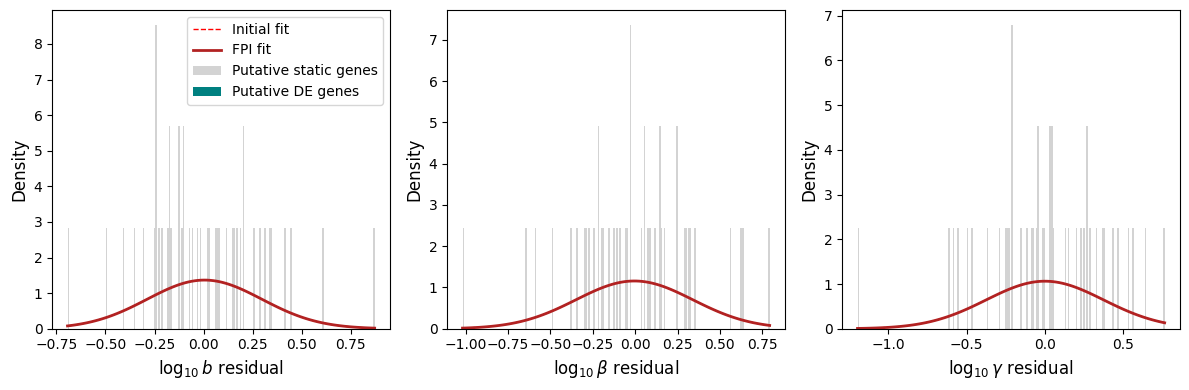

In [51]:
#thrpars --> min log2FC
#thrmean --> mean expr to keep gene
clus1 = np.unique(cluster_assignments)[0] #clusters to compare for DE-theta
clus2 = np.unique(cluster_assignments)[2]

all_filt_fcs = make_fcs(chosen_sr,chosen_sd[0],clus1=clus1,clus2=clus2,
                gf_rej=True,thrpars=1.5,thrmean=0.1,outlier_de=True,correct_off=True) #FC of 3/4

all_filt_fcs.head()

In [52]:
#Save results
all_filt_fcs.to_csv(dir_string+'day3_detheta_res.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
#Assign DE genes to which cluster they are a 'marker' of
out_marks = get_gene_DE(all_filt_fcs)

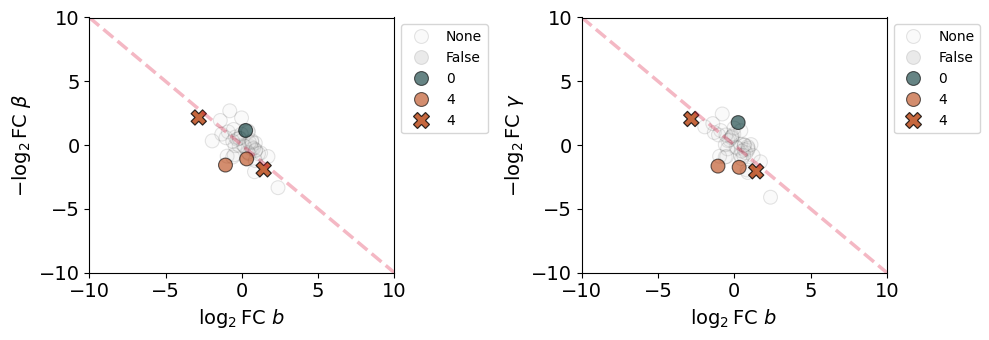

In [54]:
#Plot DE Genes

dt_palette = palette={clus1:'#003333',clus2:'#b7410e','None':'lightgrey'}

names_plot = [] #e.g. ['HMMR','NANOG']
mark_plot = []
xpos = []
ypos = []
arrow = []

plot_de(out_marks,names_plot ,mark_plot,xpos,ypos,arrow,
        assign_colors=dt_palette,
        figsize=(10,3.5),fname='DT_'+str(clus1)+'_vs_'+str(clus2)+'.pdf',xlims=[-10,10])



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
